In [1]:
%load_ext autoreload
%autoreload 2

from topologylayer.nn import AlphaLayer, BarcodePolyFeature, PartialSumBarcodeLengths
from gtda.plotting import plot_point_cloud
from persim import plot_diagrams
from takenslayers import *
import matplotlib.pyplot as plt

import math

import numpy as np
from scipy.signal import convolve

import torch
from torch.autograd import Variable
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F

torch.manual_seed(2)

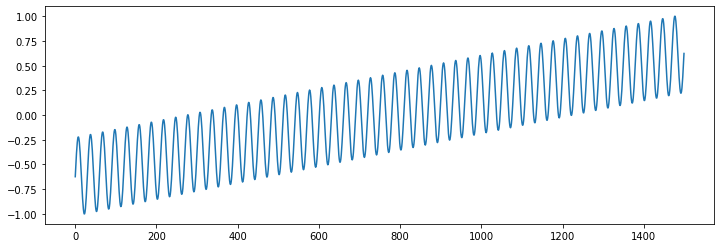

In [2]:
n_periods = 50
samples_per_period = 30
N = n_periods*samples_per_period
t = np.linspace(0, 2*np.pi*n_periods, N)
x = np.sin(t) + 0.01*t
x = x-np.min(x)
x /= np.max(x)
x = x*2-1
plt.figure(figsize=(12, 4))
plt.plot(x)

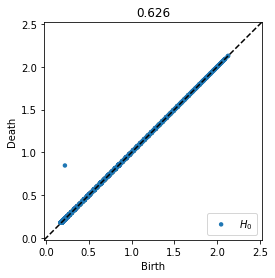

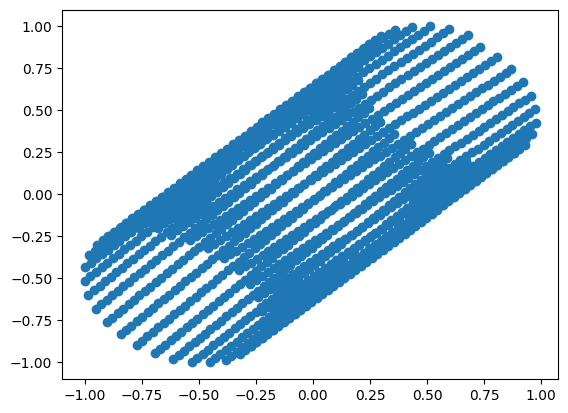

In [3]:
## Experimenting with the code for a few different ideas
model = nn.Sequential(
    SlidingWindowLayer(win=samples_per_period, dim=3, dT=2),
    nn.Flatten(start_dim=0, end_dim=1),
    Transpose(),
    AlphaLayer(maxdim=1)
)



data = torch.from_numpy(x.reshape(1, 1, -1)).float()
res = model(data)
dgm1 = res[0][1].detach().numpy()
plt.figure()
plot_diagrams(dgm1)
plt.title("{:.3f}".format(np.max(dgm1[:, 1]-dgm1[:, 0])))

plt.figure()
L = SlidingWindowLayer(win=samples_per_period, dim=3, dT=1)
Y = L(data).detach().numpy()
Y = Y[0, :, :].T
plt.scatter(Y[:, 0], Y[:, 1])

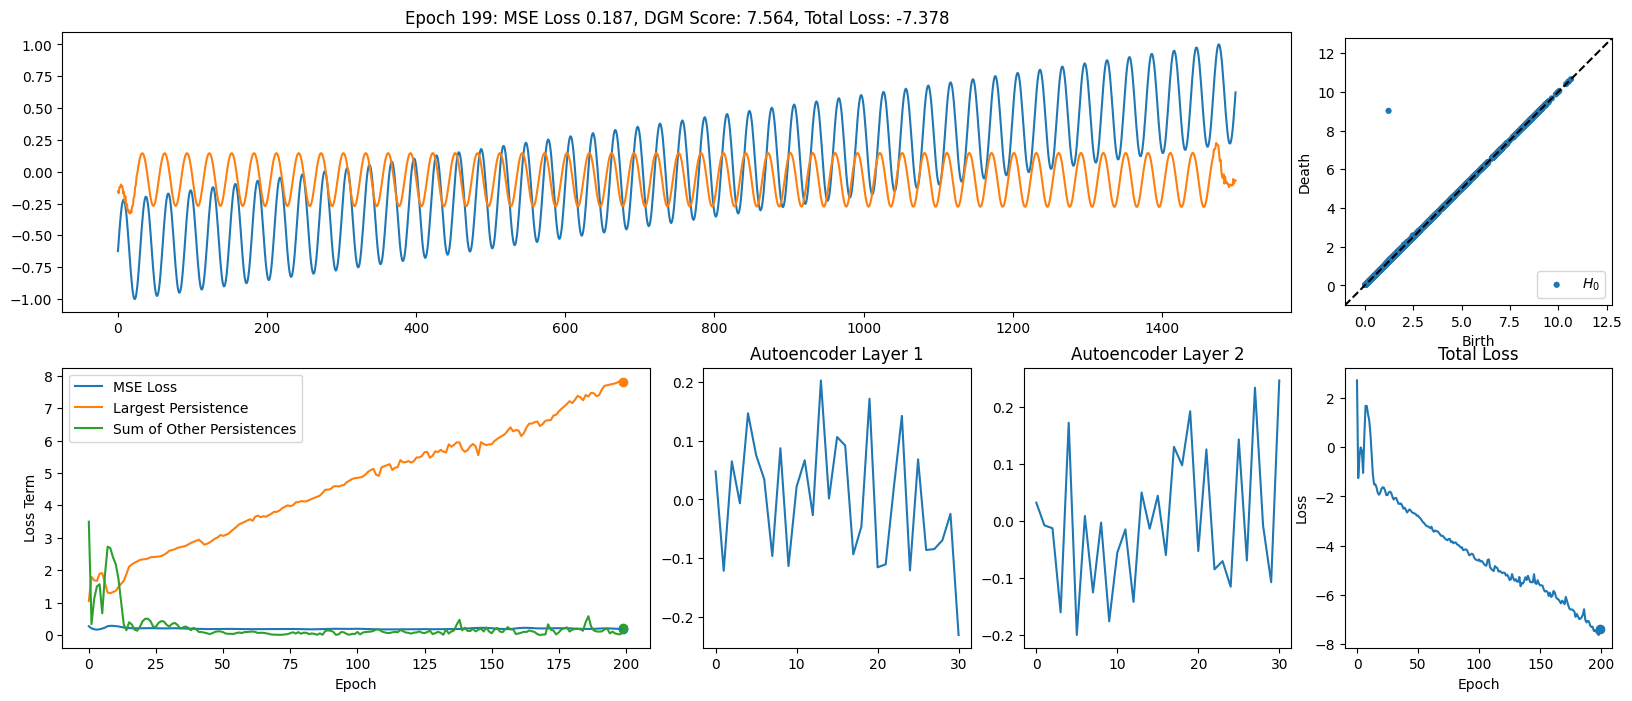

In [4]:
class SlidingAutoencoder(nn.Module):
    def __init__(self, x, dim, win, lam=1, lr=1e-2):
        """
        Parameters
        ----------
        x: ndarray(N)
            Time series
        dim: int
            Dimension of embedding
        win: int
            Window size
        lam: float
            Weight of topological regularization
        lr: float
            Learning rate
        """
        super(SlidingAutoencoder, self).__init__()
        self.x_orig = x
        self.x = torch.from_numpy(x.reshape(1, 1, -1)).float()
        self.win = win
        self.dim = dim
        self.lam = lam
        ## Part 1: Autoencoder
        ## TODO: This could be an RNN, and there could also be more layers
        self.linear1 = nn.Conv1d(1, 1, win+1, stride=1, padding='same')
        self.linear1_tanh = nn.Tanh()
        self.linear2 = nn.Conv1d(1, 1, win+1, stride=1, padding='same')
        self.linear2_tanh = nn.Tanh()
        self.batchnorm = nn.BatchNorm1d(1)
        ## Part 2: Sliding Window
        self.swlayer = SlidingWindowLayer(win=win, dim=dim, dT=2)# Stride 2 for speed
        self.flatten = nn.Flatten(start_dim=0, end_dim=1)
        self.transpose = Transpose()
        #self.znorm = ZNormalize()
        ## Part 3: TDA
        self.alpha = AlphaLayer(maxdim=1)
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        
        # Loss functions and losses
        self.mse_loss = nn.MSELoss()
        self.sum_h1_loss = PartialSumBarcodeLengths(dim=1, skip=0)
        self.skip1_sum_h1_loss = PartialSumBarcodeLengths(dim=1, skip=1)
        self.losses = []
    
    def forward(self):
        """
        Returns
        -------
        y: The warped time series
        dgms: The persistence diagrams of the sliding widow embedding of the
              warped time series
        """
        y = self.linear1(self.x)
        y = self.linear1_tanh(y)
        y = self.linear2(y)
        y = self.linear2_tanh(y)
        sw = self.swlayer(self.batchnorm(y))
        sw = self.flatten(sw)
        sw = self.transpose(sw)
        #sw = self.znorm(sw)
        dgms = self.alpha(sw)
        return y, dgms
    
    def train_step(self):
        self.optimizer.zero_grad()
        self.train()
        y, dgms = self.forward()
        mse_loss = self.mse_loss(self.x, y)
        sum_h1_loss = self.sum_h1_loss(dgms)
        skip1_sum_h1_loss = self.skip1_sum_h1_loss(dgms)
        largest_pers = sum_h1_loss-skip1_sum_h1_loss
        dgm_score = largest_pers-skip1_sum_h1_loss
        loss = mse_loss - self.lam*dgm_score
        loss.backward()
        self.optimizer.step()
        self.losses.append(loss.item())
        return y, dgms, mse_loss.item(), self.lam*largest_pers.item(), self.lam*skip1_sum_h1_loss.item()
    
    def train_epochs(self, num_epochs):
        self.losses = []
        plot_idx = 0
        res = 4
        plt.figure(figsize=(res*5, res*2))
        y = None
        mse_losses = []
        largest_perses = []
        sum_other_persistences = []
        for epoch in range(num_epochs):
            y, dgms, mse_loss, largest_pers, sum_other_persistence = self.train_step()
            
            ## Everything below this point is just for plotting
            mse_losses.append(mse_loss)
            largest_perses.append(largest_pers)
            sum_other_persistences.append(sum_other_persistence)
            dgm_score = largest_pers-sum_other_persistence
            y = y.detach().numpy().flatten()
            plt.clf()
            plt.subplot2grid((2, 5), (0, 0), colspan=4)
            plt.plot(self.x_orig)
            plt.plot(y)
            plt.title("Epoch {}: MSE Loss {:.3f}, DGM Score: {:.3f}, Total Loss: {:.3f}".format(epoch, mse_loss, dgm_score, self.losses[-1]))
            plt.subplot2grid((2, 5), (1, 0), colspan=2)
            plt.plot(mse_losses)
            plt.plot(largest_perses)
            plt.plot(sum_other_persistences)
            plt.legend(["MSE Loss", "Largest Persistence", "Sum of Other Persistences"])
            plt.scatter([epoch], [mse_loss], c='C0')
            plt.scatter([epoch], [largest_pers], c='C1')
            plt.scatter([epoch], [sum_other_persistence], c='C2')
            #plt.ylim([0, np.quantile(np.concatenate((mse_losses, dgm_losses, birth_losses)), 0.99)])
            plt.xlabel("Epoch")
            plt.ylabel("Loss Term")
            plt.subplot2grid((2, 5), (1, 2), colspan=1)
            layer1 = list(self.parameters())[0].detach().numpy().flatten()
            plt.plot(layer1)
            plt.title("Autoencoder Layer 1")
            plt.subplot2grid((2, 5), (1, 3), colspan=1)
            layer1 = list(self.parameters())[2].detach().numpy().flatten()
            plt.plot(layer1)
            plt.title("Autoencoder Layer 2")
            
            plt.subplot2grid((2, 5), (0, 4), colspan=1, rowspan=1)
            plot_diagrams(dgms[0][1].detach().numpy())
            plt.subplot2grid((2, 5), (1, 4), colspan=1, rowspan=1)
            plt.plot(self.losses)
            plt.scatter([epoch], [self.losses[-1]])
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.title("Total Loss")
            plt.savefig("{}.png".format(plot_idx))
            plot_idx += 1
        return y

autoencoder = SlidingAutoencoder(x, lam=1, dim=3, win=samples_per_period)
y = autoencoder.train_epochs(200)

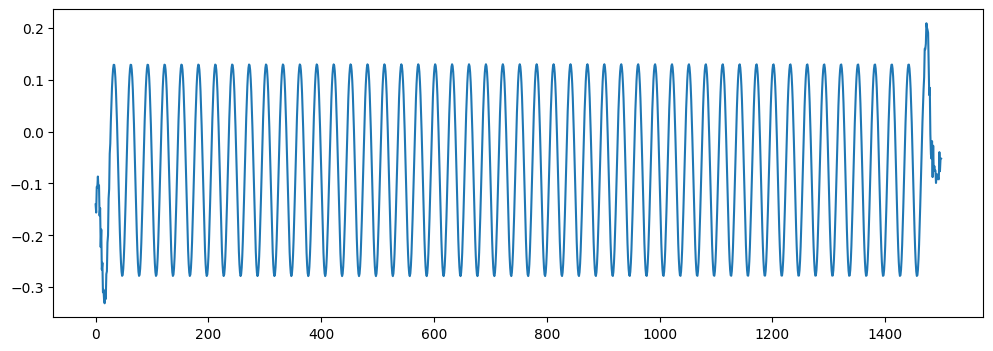

In [5]:
plt.figure(figsize=(12, 4))
y, dgms = autoencoder.forward()
plt.plot(y.detach().numpy().flatten())